# Pass clustering to see how teams penetrate into final third

In [1]:
import duckdb

import mplsoccer
from mplsoccer import Pitch, VerticalPitch

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
import numpy as np

## Primer clusteringa za eno ekipo - Chelsea

In [3]:
df_teams = duckdb.sql(f"""SELECT * FROM 'data/teams.parquet' """).df()
df_teams.tail(6)

,team_id,name,country,__index_level_0__
19,1610,Chelsea,England,19
20,1609,Arsenal,England,20
21,1614,Aston Villa,England,21
22,1624,Tottenham Hotspur,England,22
23,1626,Norwich City,England,23
24,1611,Manchester United,England,24


In [4]:
df_stories = duckdb.sql(f"""
    SELECT * FROM 'data/stories.parquet'
    WHERE team_id = 1610 AND type = 'pass'
""").df()

df_stories.head(3)

,player_position,throw_in,start_x,penalty_conceded_goal,penalty_foul,lateral_pass,own_goal,linkup_play,type,red_card,...,shot_goal_zone,conceded_goal,is_pass,possession_attack,pass_blocked,opportunity,possession_id,shot_id,possession_set_piece_attack,__index_level_0__
0,AMF,False,57,False,False,False,False,False,pass,False,...,None,False,True,True,False,False,1294897251,0,False,6336
1,LCB3,False,32,False,False,True,False,False,pass,False,...,None,False,True,True,False,False,1294897251,0,False,6337
2,CB,False,35,False,False,True,False,False,pass,False,...,None,False,True,True,False,False,1294897251,0,False,6338


In [7]:
df_stories.shape

(62117, 138)

In [11]:
# Find the maximum and minimum values for 'start_y' and 'end_y' in the DataFrame
start_y_min = df_stories['start_y'].min()
start_y_max = df_stories['start_y'].max()

end_y_min = df_stories['end_y'].min()
end_y_max = df_stories['end_y'].max()

start_y_min, start_y_max, end_y_min, end_y_max

(0, 100, 0, 100)

**Koordinate x in y so normalizirane na 100**

In [12]:
start_x_min = df_stories['start_x'].min()
start_x_max = df_stories['start_x'].max()

end_x_min = df_stories['end_x'].min()
end_x_max = df_stories['end_x'].max()

start_x_min, start_x_max, end_x_min, end_x_max

(0, 100, 0, 100)

**Podaje lahko filtriram z atributom 'pass_to_final_third'**

In [5]:
df_stories_filtered = df_stories[df_stories['pass_to_final_third']]
df_stories_filtered.shape

(6444, 138)

**Znebiti se moram vseh podaj iz prekinitev in podaj golmanov z roko**

In [6]:
# List of columns to check
columns_to_check = [
    'possession_free_kick', 'free_kick', 'free_kick_cross', 
    'possession_free_kick_cross', 'possession_direct_free_kick', 
    'possession_corner', 'corner', 'possession_set_piece_attack',
    'hand_pass'
]

# Filter out rows where any of the specified columns are True
df_stories_brez_prekinitev = df_stories_filtered[~df_stories_filtered[columns_to_check].any(axis=1)]

# Display the first few rows to verify
df_stories_brez_prekinitev.shape


(5006, 138)

**Upošteval bom uspešne in neuspešne podaje**

In [12]:
df_stories_brez_prekinitev.value_counts('successful')

successful
True     3934
False    1072
Name: count, dtype: int64

In [13]:
df_stories_brez_prekinitev.value_counts('forward_pass')

forward_pass
True     3509
False    1497
Name: count, dtype: int64

In [14]:
df_stories_brez_prekinitev.value_counts('lateral_pass')

lateral_pass
False    3771
True     1235
Name: count, dtype: int64

In [20]:
df_stories_brez_prekinitev.value_counts('head_pass')

head_pass
False    4889
True      117
Name: count, dtype: int64

In [16]:
df_stories_brez_prekinitev.value_counts('through_pass')

through_pass
False    4608
True      398
Name: count, dtype: int64

In [17]:
df_stories_brez_prekinitev.value_counts('progressive_pass')

progressive_pass
False    2872
True     2134
Name: count, dtype: int64

In [18]:
df_stories_brez_prekinitev.value_counts('long_pass')

long_pass
False    3708
True     1298
Name: count, dtype: int64

In [19]:
df_stories_brez_prekinitev.value_counts('short_or_medium_pass')

short_or_medium_pass
True     3704
False    1302
Name: count, dtype: int64

In [15]:
# rad bi videl en entry v celem
row = df_stories_brez_prekinitev.iloc[0]

# Adjust pandas settings to display all columns
pd.set_option('display.max_columns', None)  # No limit on columns
pd.set_option('display.width', None)        # Adjust width to fit data
pd.set_option('display.max_rows', None)     # Allow showing more rows if needed

# Display the row
print(row)

player_position                       LCB3
throw_in                             False
start_x                                 44
penalty_conceded_goal                False
penalty_foul                         False
lateral_pass                          True
own_goal                             False
linkup_play                          False
type                                  pass
red_card                             False
penalty_goal                         False
kept_possession                      False
xA                                     0.0
possession_free_kick                 False
shot_after_corner                    False
hand_pass                            False
key_pass                             False
game_interruption                    False
head_pass                            False
head_shot                            False
save_with_reflex                     False
assist                               False
goal_kick                            False
shot_assist

**Spremenljivke, ki me zanimajo so:**
* lateral_pass
* forward_pass
* start_x
* start_y
* end_x
* end_y
* pass_length

**pass height in pressure ne bo vplival na gručenje**

**Namesto zanašanja na lateral in forward podatek lahko zračunam kot podaje -> arctan**

In [17]:
# List of columns to keep
columns_to_keep = [
    'start_x', 
    'start_y', 
    'end_x', 
    'end_y', 
    'pass_length',
    'successful'
]

# Select only the desired columns
df_done = df_stories_brez_prekinitev[columns_to_keep]

# Display the first few rows to verify
df_done.head()

,start_x,start_y,end_x,end_y,pass_length,successful
19,44,28,73,90,52,False
29,48,24,82,11,37,True
46,63,90,67,97,6,True
49,56,46,72,9,30,True
53,45,19,83,34,41,True


### Skaliranje x in y koordinat, da se ujema s standardnim igriščem 105x68

In [18]:
# Create a copy and scale the coordinates to real pitch dimensions (105x68 meters)
df_done_copy = df_done.copy()
df_done_copy["start_x"] *= 105 / 100
df_done_copy["start_y"] *= 68 / 100
df_done_copy["end_x"] *= 105 / 100
df_done_copy["end_y"] *= 68 / 100

df_done_copy.head(3)

,start_x,start_y,end_x,end_y,pass_length,successful
19,46.20,19.04,76.65,61.20,52,False
29,50.40,16.32,86.10,7.48,37,True
46,66.15,61.20,70.35,65.96,6,True


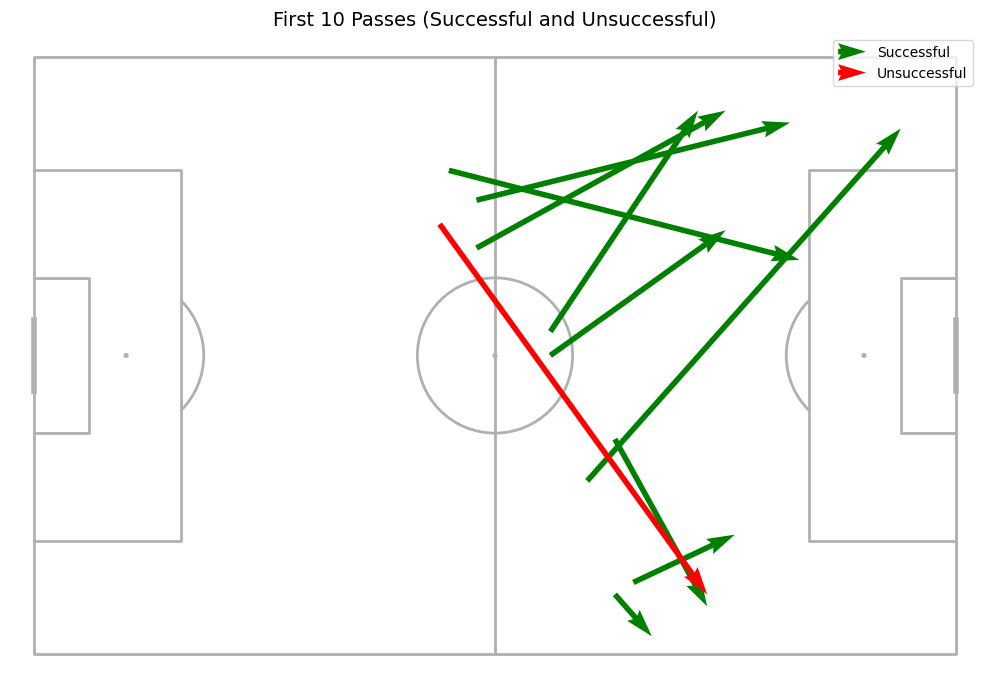

In [19]:
# Get the first 10 passes
df_first_10_passes = df_stories_filtered.head(10)

# Create the pitch
pitch = Pitch(pitch_type='wyscout')
fig, ax = pitch.draw(figsize=(10, 7))

# Plot successful passes (green)
pitch.arrows(
    df_first_10_passes[df_first_10_passes['successful']]['start_x'],
    df_first_10_passes[df_first_10_passes['successful']]['start_y'],
    df_first_10_passes[df_first_10_passes['successful']]['end_x'],
    df_first_10_passes[df_first_10_passes['successful']]['end_y'],
    ax=ax, color='green', label='Successful'
)

# Plot unsuccessful passes (red)
pitch.arrows(
    df_first_10_passes[~df_first_10_passes['successful']]['start_x'],
    df_first_10_passes[~df_first_10_passes['successful']]['start_y'],
    df_first_10_passes[~df_first_10_passes['successful']]['end_x'],
    df_first_10_passes[~df_first_10_passes['successful']]['end_y'],
    ax=ax, color='red', label='Unsuccessful'
)

# Add legend and title
plt.legend()
plt.title('First 10 Passes (Successful and Unsuccessful)', fontsize=14)
plt.show()


In [20]:
df_done_copy["angle"] = np.arctan2(df_done_copy["end_y"] - df_done_copy["start_y"], df_done_copy["end_x"] - df_done_copy["start_x"])
df_done_copy.head()

,start_x,start_y,end_x,end_y,pass_length,successful,angle
19,46.20,19.04,76.65,61.20,52,False,0.945294
29,50.40,16.32,86.10,7.48,37,True,-0.242737
46,66.15,61.20,70.35,65.96,6,True,0.847817
49,58.80,31.28,75.60,6.12,30,True,-0.982060
53,47.25,12.92,87.15,23.12,41,True,0.250279


In [21]:
df_done_copy.dtypes

start_x        float64
start_y        float64
end_x          float64
end_y          float64
pass_length      int64
successful        bool
angle          float64
dtype: object

## Določanje optimalno število gruč

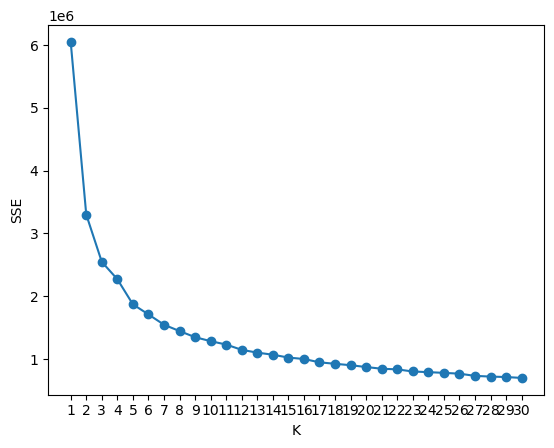

Text(0.5, 0, 'k')

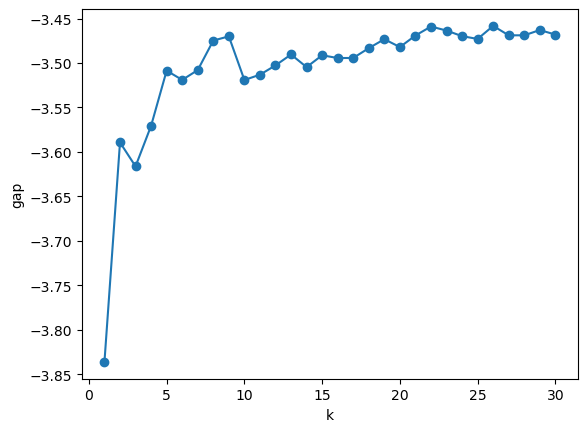

In [22]:
from sklearn.cluster import KMeans

K = np.linspace(1, 30, 30)
X = df_done_copy[["start_x", "start_y", "end_x", "end_y", "angle", "pass_length"]].values
elbow = {"sse": [], "k": [], "sil": []}
for k in K:
    cluster = KMeans(n_clusters = int(k), random_state = 2147)
    labels = cluster.fit_predict(X)
    elbow["sse"].append(cluster.inertia_)
    elbow["k"].append(k)

plt.scatter(elbow["k"], elbow["sse"])
plt.plot(elbow["k"], elbow["sse"])
plt.xticks(np.linspace(1, 30, 30))
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()
from sklearn.metrics import pairwise_distances
def compute_inertia(a, X):
    W = [np.mean(pairwise_distances(X[a == c, :])) for c in np.unique(a)]
    return np.mean(W)

def compute_gap(clustering, data, k_max, n_references=5):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(reference)
            local_inertia.append(compute_inertia(assignments, reference))
        reference_inertia.append(np.mean(local_inertia))

    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(data)
        ondata_inertia.append(compute_inertia(assignments, data))

    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

k_max = 30
gap, reference_inertia, ondata_inertia = compute_gap(KMeans(random_state = 2147), X, k_max)

plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')

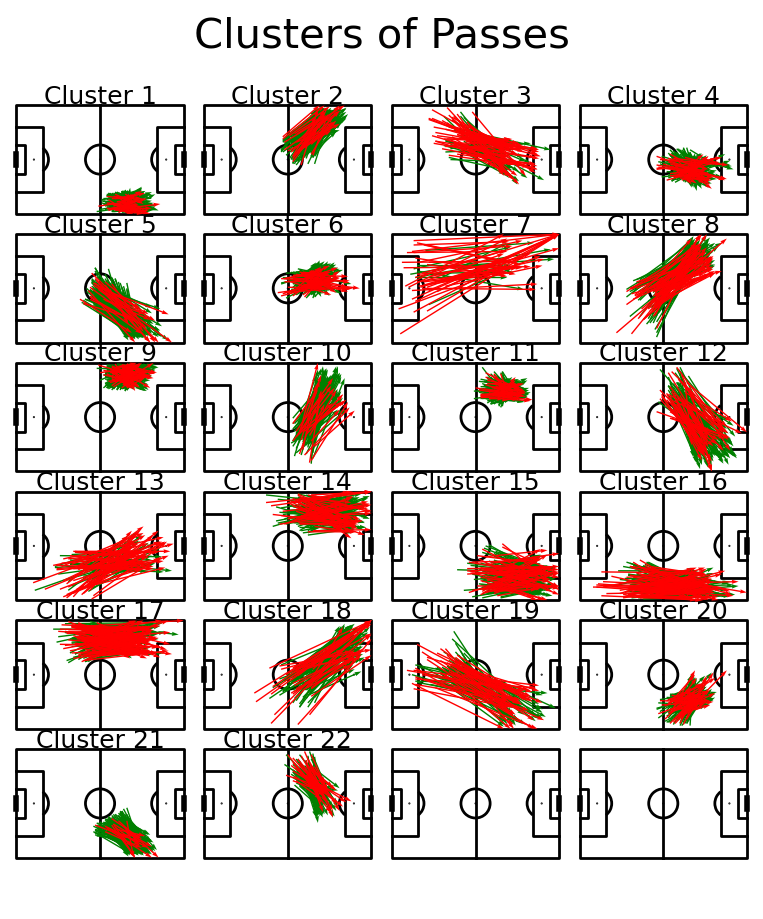

In [23]:
# Perform clustering
k = 22  # Number of clusters determined by Gap Statistic
cluster = KMeans(n_clusters=k, random_state=2147)
labels = cluster.fit_predict(df_done_copy[["start_x", "start_y", "end_x", "end_y", "angle"]].values)

# Add cluster labels to the dataframe
df_done_copy["label"] = labels

# Set up the pitch
pitch = Pitch(line_color='black', pitch_type="custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(
    ncols=4, nrows=6, grid_height=0.85, title_height=0.06, axis=False,
    endnote_height=0.04, title_space=0.04, endnote_space=0.01
)

# Plot each cluster on a separate pitch
for clust, ax in zip(range(k), axs['pitch'].flat[:k]):
    # Add cluster label as title for each subplot
    ax.text(52.5, 74, f"Cluster {clust + 1}",
            ha='center', va='center', fontsize=18)
    
    # Filter passes belonging to the current cluster
    clustered = df_done_copy[df_done_copy["label"] == clust]
    
    # Separate successful and unsuccessful passes
    successful = clustered[clustered["successful"]]
    unsuccessful = clustered[~clustered["successful"]]
    
    # Plot successful passes (green)
    pitch.arrows(
        successful["start_x"], successful["start_y"],
        successful["end_x"], successful["end_y"],
        color="green", ax=ax, width=1, label="Successful"
    )
    
    # Plot unsuccessful passes (red)
    pitch.arrows(
        unsuccessful["start_x"], unsuccessful["start_y"],
        unsuccessful["end_x"], unsuccessful["end_y"],
        color="red", ax=ax, width=1, label="Unsuccessful"
    )

# Set the overall title
axs['title'].text(0.5, 0.5, 'Clusters of Passes', ha='center', va='center', fontsize=30)
plt.show()